### Base on the original notebook from https://fa.bianp.net/blog/2022/adaptive_fw/


In [ ]:
!pip install git+https://github.com/openopt/copt.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openopt/copt.git to /tmp/pip-req-build-u_x43mxq
  Running command git clone -q https://github.com/openopt/copt.git /tmp/pip-req-build-u_x43mxq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for copt: filename=copt-0.9.0-py3-none-any.whl size=37601 sha256=a600f02dd5baf8222daedcede16e99929abc1dcee352cc6c4430e191305627cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-ntbucnkl/wheels/5a/2c/24/8c054b4fcfd93eec7d7b66ffe099ebc66fabbb9fe06f6bb982
Successfully built copt


In [ ]:
%%capture
import matplotlib.font_manager as fm

# for nicer fonts
!wget https://github.com/openmaptiles/fonts/raw/master/open-sans/OpenSans-Light.ttf
fm.fontManager.ttflist += fm.createFontList(['OpenSans-Light.ttf'])

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors

from matplotlib import rcParams
from matplotlib.ticker import StrMethodFormatter
rcParams['font.size'] = 35
rcParams['font.family'] = 'Open Sans'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'

import numpy as np
from scipy import special
from scipy import optimize

In [ ]:
colors = ['#f1a340', '#998ec3']
gamma0 = [0.0]
def plot_contours(f_grad, delta = 1e-1):
  x = np.arange(-3.0, 3.1, delta)
  y = np.arange(-3.0, 3.1, delta)
  X, Y = np.meshgrid(x, y)
  Z = np.empty_like(X)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Z[i, j] = f_grad((X[i, j], Y[i, j]))[0]
  
  fig, ax = plt.subplots(1, 1, figsize=(12, 7))
  tt = np.floor(np.linspace(0, np.sqrt(np.max(Z - np.min(Z))), 10) ** 2)
  cs = ax.contour(X, Y, Z - np.min(Z), linewidths=3)
  return ax

def f_grad(x):
  x = np.asarray(x)
  grad = 2 * H.dot(x) - b
  loss = x.dot(H).dot(x) - x.dot(b) 
  return loss, grad

def exact_ls_fw(kw):
  """Exact line-search for the Frank-Wolfe algorithm."""

  def f_ls(gamma):
    obj, grad_x = kw["f_grad"](kw["x"] + gamma[0] * kw["d_t"])
    grad_gamma = np.dot(grad_x, kw["d_t"])
    return obj, np.array(grad_gamma)

  # Although there are scalar minimizations routines in scipy, the classical
  # L-BFGS-B method seems to be working much better at finding the optimal
  # step-size.
  ls_sol = optimize.minimize(
    f_ls, gamma0, bounds=[[0, 1]], method="L-BFGS-B", jac=True, tol=1e-20)

  # keep gamma0 as a warm start for next iterate
  gamma0[0] = ls_sol.x[0]
  return ls_sol.x[0]

def exact_ls_gd(kw):
  """Exact line-search for the Frank-Wolfe algorithm."""

  def f_ls(gamma):
    obj, grad_x = kw["f_grad"](kw["x"] + gamma[0] * kw["g_t"])
    grad_gamma = np.dot(grad_x, kw["g_t"])
    return obj, np.array(grad_gamma)

  # Although there are scalar minimizations routines in scipy, the classical
  # L-BFGS-B method seems to be working much better at finding the optimal
  # step-size.
  ls_sol = optimize.minimize(
    f_ls, gamma0, method="L-BFGS-B", jac=True, tol=1e-20)

  # keep gamma0 as a warm start for next iterate
  gamma0[0] = ls_sol.x[0]
  return ls_sol.x[0]

In [ ]:
class QuadraticForm:
    def __init__(self, A, b, alpha=0):
        self.b = b
        self.alpha = alpha
        self.A = A

    def __call__(self, x):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss

    def f_grad(self, x, return_gradient=True):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss, grad


In [ ]:
from datetime import datetime
class Trace:
    """Trace callback."""
    def __init__(self, f=None, freq=1):
        self.trace_x = []
        self.trace_time = []
        self.trace_fx = []
        self.trace_step_size = []
        self.start = datetime.now()
        self._counter = 0
        self.freq = int(freq)
        self.f = f

    def __call__(self, dl):
        if self._counter % self.freq == 0:
            self.trace_fx.append(self.f(dl["x"]))
            self.trace_x.append(dl["x"].copy())
            delta = (datetime.now() - self.start).total_seconds()
            self.trace_time.append(delta)
            self.trace_step_size.append(dl["step_size"])
        self._counter += 1
    


In [ ]:
def armijo_step_size(x):
    inequality_satisfied = True
    step_size_t = 1
    c1 = 0.05
    f_grad = copt.utils.build_func_grad(x['jac'], x['fun'], x['args'], x['eps'])
    current_grad = f_grad(x['x'])[1]
    #i = 0
    for _ in range(5):
      f_next, grad_next = f_grad(x['x'] - step_size_t * x['update_direction'])
      if f_grad(x['x'] + step_size_t * x['update_direction'])[0] <= x['f_t'] + step_size_t * c1 * current_grad.dot(x['update_direction']):
        break
      else:
        #i += 1
        step_size_t = step_size_t//2
    return step_size_t

Estimated L_t = 0.1666666666666483
Estimated L_t = 0.14409221902011993
Estimated L_t = 0.002656042496718136
Estimated L_t = 0.2059202059202514
Estimated L_t = 0.001162115049413437
Estimated L_t = 0.23814541622757535
Estimated L_t = 0.14858841010401136
Estimated L_t = 0.20336448598134993
Estimated L_t = 0.14992503748123553
Estimated L_t = 0.06335797254486408
Estimated L_t = 0.24381625441693977
Estimated L_t = 0.38637074085656753
Estimated L_t = 0.26255707762556924
Estimated L_t = 0.0780222272623865
Estimated L_t = 0.14788226848527763
Estimated L_t = 0.0004122011541540793
Estimated L_t = 0.1666666666666483
Estimated L_t = 0.11072664359856876
Estimated L_t = 0.12472160356347128
Estimated L_t = 0.16810683424983708
Estimated L_t = 0.37346791636627685
Estimated L_t = 0.35593220338980824
Estimated L_t = 0.31399631675876893
Estimated L_t = 0.347750865051899
Estimated L_t = 0.07145931984497977
Estimated L_t = 0.25957727873182623
Estimated L_t = 0.13950018649755425
Estimated L_t = 0.113733905579

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Estimated L_t = 0.019607843137259273
Estimated L_t = 0.019275700934628937
Estimated L_t = 0.020220310849583534
Estimated L_t = 0.017863277224305918
Estimated L_t = 0.013045734193140035
Estimated L_t = 0.007365742600740077
Estimated L_t = 0.03231238816969739
Estimated L_t = 0.00814291649353649
Estimated L_t = 0.002819618609484209
Estimated L_t = 0.03069665927413201
Estimated L_t = 0.021533211743252068
Estimated L_t = 0.043580102323859116
Estimated L_t = 0.02884156776927771
Estimated L_t = 0.028065089926920805
Estimated L_t = 0.03271701406504235
Estimated L_t = 0.01434923635423857
Estimated L_t = 0.019607843137259273
Estimated L_t = 0.010705289672507945
Estimated L_t = 0.027015498364812984
Estimated L_t = 0.009108910891120203
Estimated L_t = 0.027257488521281736
Estimated L_t = 0.004749930148095771
Estimated L_t = 0.005094503031211062
Estimated L_t = 0.002814982973942115
Estimated L_t = 0.0025660127472848515
Estimated L_t = 0.0335079977936692
Estimated L_t = 0.04163022564285246
Estimated

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Estimated L_t = 0.0019960079840064537
Estimated L_t = 0.0003817036706710297
Estimated L_t = 0.0032566845733494887
Estimated L_t = 0.0012277100188695655
Estimated L_t = 0.00240825248298826
Estimated L_t = 0.001522465887249247
Estimated L_t = 0.0021503639465736413
Estimated L_t = 0.002100472606292314
Estimated L_t = 0.0021510070443708784
Estimated L_t = 0.0021486802468384525
Estimated L_t = 0.002341215009860065
Estimated L_t = 0.002203586949911518
Estimated L_t = 0.001954523003888653
Estimated L_t = 0.0031029400356930026
Estimated L_t = 0.003911667437184185
Estimated L_t = 0.0020213437398330925
Estimated L_t = 0.0019960079840064537
Estimated L_t = 0.0038245488227506286
Estimated L_t = 0.0018107602123285105
Estimated L_t = 0.0036582232955106875
Estimated L_t = 0.0014270535222404845
Estimated L_t = 0.0023845259997656854
Estimated L_t = 0.0003154702542529364
Estimated L_t = 0.0035747008670927727
Estimated L_t = 0.002251841268452459
Estimated L_t = 0.001790253368660899
Estimated L_t = 0.0002

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


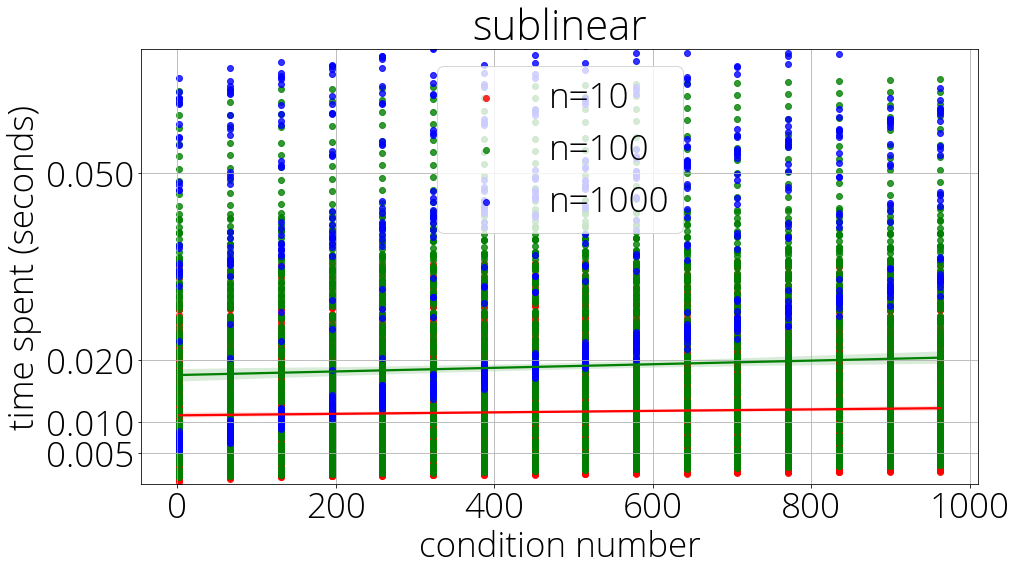

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copt as cp

# .. datasets and their loading functions ..
import copt.constraint
import copt.loss
n = 100


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copt as cp

# .. datasets and their loading functions ..
import copt.constraint
import copt.loss
class QuadraticForm:
    def __init__(self, A, b, alpha=0):
        self.b = b
        self.alpha = alpha
        self.A = A

    def __call__(self, x):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss

    def f_grad(self, x, return_gradient=True):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss, grad
    @property
    def lipschitz(self):
        return np.linalg.eig(self.A)[0].max()

colors = ['red', 'green', 'blue']


error_rate = 1e-6
for method in ['sublinear']:
  j = 0
  plt.figure(figsize = (15, 8))
  for n in [10, 100, 1000]:
    averaged_iters_vs_cns = []
    cns = []
    iters = []
    for i in range(1, 32):
      for k in range(3, 1000, 64):
        b = np.random.uniform(0, 1, n)
        H = np.diag(np.random.choice(range(1, k-1), n))
        H[0,0]=1
        H[n-1,n-1]=k
        H = H/H.sum()
        cns.append(k)
        l1_ball = copt.constraint.L1Ball(1)
        f = QuadraticForm(H, b)
        x0 = np.zeros(n)

        #for step, label, marker in variants_fw:

        cb = Trace(f)
        if method == 'DR':
          sol = cp.minimize_frank_wolfe(
              f.f_grad, x0, l1_ball.lmo, callback=cb, step=method,tol = error_rate, lipschitz=f.lipschitz, max_iter = 30000
          )
        else:
          sol = cp.minimize_frank_wolfe(
              f.f_grad, x0, l1_ball.lmo, callback=cb, step=method,tol = error_rate, max_iter = 30000
          )
        #print('time taken:', cb.trace_time)
        iters.append(cb._counter)
      iters_vs_cns = np.array([[x, y] for x,y in zip(cns, cb.trace_time)])
      iters_vs_cns = iters_vs_cns[iters_vs_cns[:, 1].argsort()]
      if i == 1:
        averaged_iters_vs_cns = iters_vs_cns
      else:
        averaged_iters_vs_cns = np.append(averaged_iters_vs_cns, iters_vs_cns, axis = 0)
    print('LEN:', len(averaged_iters_vs_cns))
    #plt.scatter(averaged_iters_vs_cns[:,0 ], averaged_iters_vs_cns[:, 1], color=colors[j], label = f'n={n}', zorder=j)
    sns.regplot(averaged_iters_vs_cns[:,0 ], averaged_iters_vs_cns[:, 1], color=colors[j], scatter=True, label=f'n={n}')
    #plt.yscale('log')
    plt.ylabel('time spent (seconds)')
    plt.xlabel('condition number')
    plt.legend()
    plt.title(method)
    
    # Major ticks every 20, minor ticks every 5
    #major_ticks = np.arange(0, 10**4, 100)
    #minor_ticks = np.arange(0, 10**4, 5)

    #plt.xticks(major_ticks)
    #plt.xticks(minor_ticks, minor=True)
    plt.yticks([0.005, 0.01, 0.02, 0.05, 0.1, 0.2])
    #plt.yticks([5, 10**2/2, 10**3/2, 10**4/2])
    #plt.xticks([250, 500, 750, 1000])
    #plt.xticks([250, 500, 750, 1000])
    if method == 'DR':
      plt.ylim([0, 0.25])
    else:
      plt.ylim([0, 0.07])
    plt.grid()
    j += 1
  plt.show()

  #ax = plot_contours(f_grad)
  #ax.scatter([x[0] for x in cb.trace_x], [x[1] for x in cb.trace_x], color=colors[0])

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copt as cp

# .. datasets and their loading functions ..
import copt.constraint
import copt.loss
n = 100


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copt as cp

# .. datasets and their loading functions ..
import copt.constraint
import copt.loss
class QuadraticForm:
    def __init__(self, A, b, alpha=0):
        self.b = b
        self.alpha = alpha
        self.A = A

    def __call__(self, x):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss

    def f_grad(self, x, return_gradient=True):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss, grad
    @property
    def lipschitz(self):
        return np.abs(np.linalg.eig(self.A)[0]).max()

colors = ['red', 'green', 'blue']


error_rate = 1e-6
for method in ['backtracking']:
  j = 0
  plt.figure(figsize = (15, 8))
  for n in [10, 100, 1000]:
    averaged_iters_vs_cns = []
    cns = []
    iters = []
    for i in range(1, 32):
      for k in range(3, 1000, 64):
        b = np.random.uniform(0, 1, n)
        H = np.diag(np.random.choice(range(1, k-1), n))
        H[n-1,n-1]=k
        #H = H/H.sum()
        H[0,0]=1
        cns.append(k)
        l1_ball = copt.constraint.L1Ball(1)
        f = QuadraticForm(H, b)
        x0 = np.zeros(n)

        #for step, label, marker in variants_fw:

        cb = Trace(f)
        if method == 'DR':
          sol = cp.minimize_frank_wolfe(
              f.f_grad, x0, l1_ball.lmo, callback=cb, step=method,tol = error_rate, lipschitz=f.lipschitz, max_iter = 30000
          )
        else:
          sol = cp.minimize_frank_wolfe(
              f.f_grad, x0, l1_ball.lmo, callback=cb, step=method,tol = error_rate, max_iter = 30000
          )
        iters.append(cb._counter)
      iters_vs_cns = np.array([[x, y] for x,y in zip(cns, iters)])
      iters_vs_cns = iters_vs_cns[iters_vs_cns[:, 1].argsort()]
      if i == 1:
        averaged_iters_vs_cns = iters_vs_cns
      else:
        averaged_iters_vs_cns = np.append(averaged_iters_vs_cns, iters_vs_cns, axis = 0)
    print('LEN:', len(averaged_iters_vs_cns))
    plt.scatter(averaged_iters_vs_cns[:,0 ], averaged_iters_vs_cns[:, 1], color=colors[j], label = f'n={n}', zorder=j, linewidth=0.05)
    plt.plot(averaged_iters_vs_cns[:,0 ], [np.median(averaged_iters_vs_cns[:, 1])]*len(averaged_iters_vs_cns[:,0 ]), color=colors[j], linewidth=3.64)
    #sns.regplot(averaged_iters_vs_cns[:,0 ], averaged_iters_vs_cns[:, 1], color=colors[j], scatter=True, label=f'n={n}')
    plt.yscale('log')
    #plt.ylabel('number of iterations (log scale)')
    plt.xlabel('condition number')
    plt.legend()
    plt.title(f'{method}; median')
    
    # Major ticks every 20, minor ticks every 5
    #major_ticks = np.arange(0, 10**4, 100)
    #minor_ticks = np.arange(0, 10**4, 5)

    #plt.xticks(major_ticks)
    #plt.xticks(minor_ticks, minor=True)
    plt.yticks([2, 5, 10, 10**2/2, 10**2, 10**3/2, 10**3, 10**4/2,10**4])
    #plt.yticks([5, 10**2/2, 10**3/2, 10**4/2])
    plt.xticks([250, 500, 750, 1000])
    #plt.xticks([250, 500, 750, 1000])
    plt.ylim([1, 50])
    plt.grid()
    j += 1
  plt.show()

  #ax = plot_contours(f_grad)
  #ax.scatter([x[0] for x in cb.trace_x], [x[1] for x in cb.trace_x], color=colors[0])

Estimated L_t = 6.000000000000005
Estimated L_t = 2.0000000000000018
Estimated L_t = 148.00000000000003
Estimated L_t = 65.99999999999994
Estimated L_t = 2.0000000000000018
Estimated L_t = 233.99999999999997
Estimated L_t = 774.0
Estimated L_t = 2.0000000000000018
Estimated L_t = 2.0000000000000018
Estimated L_t = 796.0
Estimated L_t = 189.99999999999994
Estimated L_t = 830.0
Estimated L_t = 75.99999999999996
Estimated L_t = 284.0
Estimated L_t = 1358.0
Estimated L_t = 1906.0
Estimated L_t = 2.0000000000000018
Estimated L_t = 2.0000000000000018
Estimated L_t = 213.99999999999997
Estimated L_t = 142.0
Estimated L_t = 120.0
Estimated L_t = 646.0
Estimated L_t = 654.0
Estimated L_t = 46.00000000000004
Estimated L_t = 1000.0
Estimated L_t = 1158.0
Estimated L_t = 612.0
Estimated L_t = 2.0000000000000018
Estimated L_t = 1390.0
Estimated L_t = 776.0
Estimated L_t = 1798.0
Estimated L_t = 62.00000000000006
Estimated L_t = 2.0000000000000018
Estimated L_t = 134.0
Estimated L_t = 148.0000000000

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copt as cp

# .. datasets and their loading functions ..
import copt.constraint
import copt.loss
class QuadraticForm:
    def __init__(self, A, b, alpha=0):
        self.b = b
        self.alpha = alpha
        self.A = A

    def __call__(self, x):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss

    def f_grad(self, x, return_gradient=True):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss, grad
    @property
    def lipschitz(self):
        return np.linalg.eig(self.A)[0].max()

colors = ['red', 'green', 'blue'] #'orange']

plt.figure(figsize = (12, 7))
j = 0
for n in [10, 100, 1000]:
  averaged_iters_vs_cns = []
  cns = []
  iters = []
  for i in range(1, 10):
    for k in range(50, 1500, 64):
      b = np.random.uniform(0, 1, n)
      H = np.diag(np.random.choice(range(1, k-1), n))
      H[0,0]=1
      H[n-1,n-1]=k
      H = H/H.sum()
      cns.append(k)
      l1_ball = copt.constraint.L1Ball(1)
      f = QuadraticForm(H, b)
      x0 = np.zeros(n)

      #for step, label, marker in variants_fw:
      cb = Trace(f)
      sol = cp.minimize_frank_wolfe(
          f.f_grad, x0, l1_ball.lmo, callback=cb, step='sublinear',tol = 1e-6, max_iter = 30000, lipschitz=f.lipschitz
      )
      #print('time taken:', cb.trace_time)
      iters.append(cb._counter)
    iters_vs_cns = np.array([[x, y] for x,y in zip(cns, iters)])
    iters_vs_cns = iters_vs_cns[iters_vs_cns[:, 1].argsort()]
    if i == 1:
      averaged_iters_vs_cns = iters_vs_cns
    else:
      averaged_iters_vs_cns = np.append(averaged_iters_vs_cns, iters_vs_cns, axis = 0)
  print('LEN:', len(averaged_iters_vs_cns))
  #plt.scatter(averaged_iters_vs_cns[:,0 ], averaged_iters_vs_cns[:, 1], color=colors[j], label = f'n={n}', zorder=j)
  sns.regplot(averaged_iters_vs_cns[:,0 ], averaged_iters_vs_cns[:, 1], color=colors[j], scatter=True, label=f'n={n}')
  plt.yscale('log')
  plt.ylabel('number of iterations (log scale)')
  plt.xlabel('condition number')
  plt.legend()
  plt.title('sublinear')
  j += 1
plt.show()

  #ax = plot_contours(f_grad)
  #ax.scatter([x[0] for x in cb.trace_x], [x[1] for x in cb.trace_x], color=colors[0])

Estimated L_t = 1.6282627765265199
(2, 1027)
Estimated L_t = 1.7711650916236195
(2, 283)
Estimated L_t = 1.7870675380684862
(2, 39)
(2, 8)
(2, 6)
(2, 4)
Estimated L_t = 1.6282627765265199
(2, 13)
Estimated L_t = 1.7711650916236195
(2, 8)
Estimated L_t = 1.7870675380684862
(2, 8)


<Figure size 864x504 with 0 Axes>

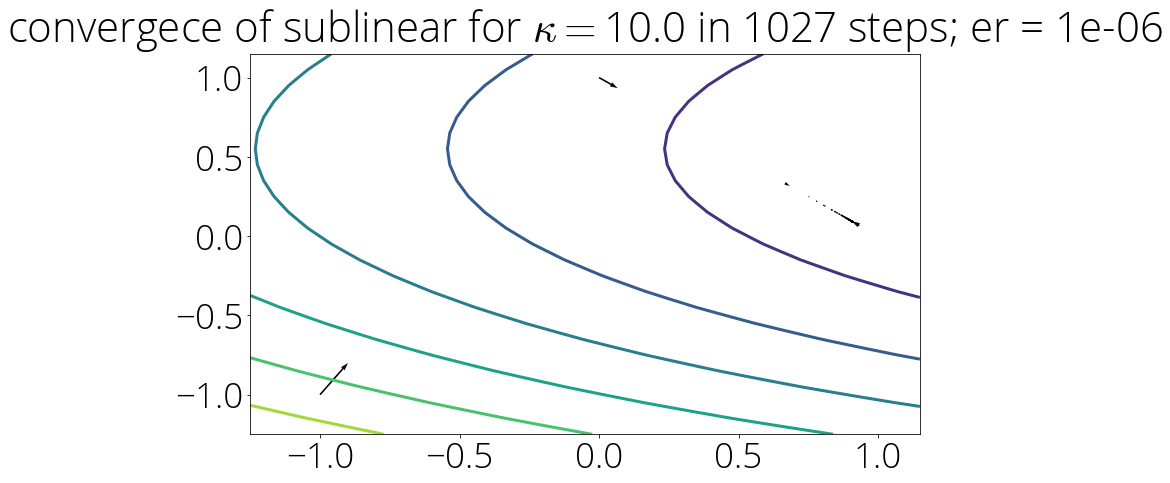

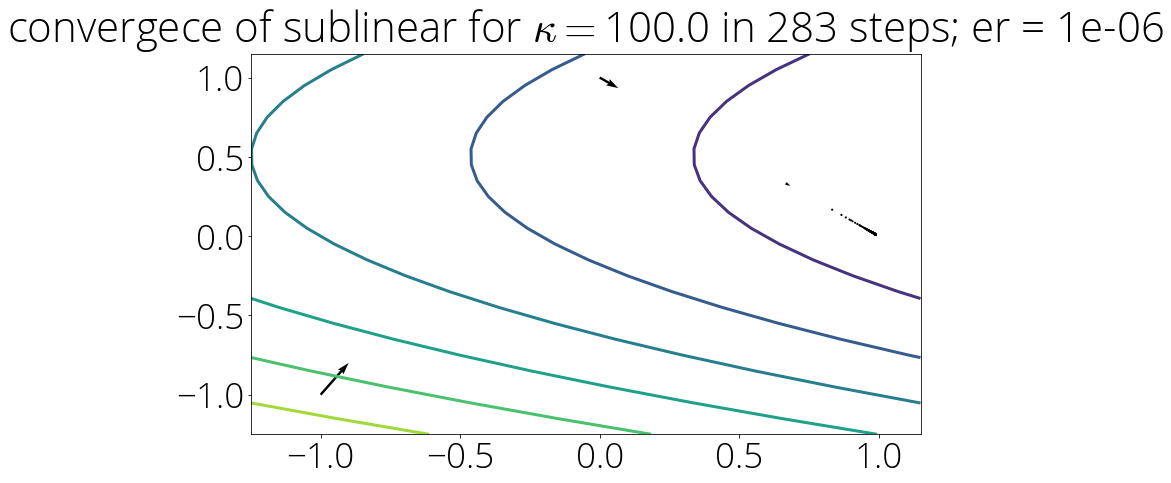

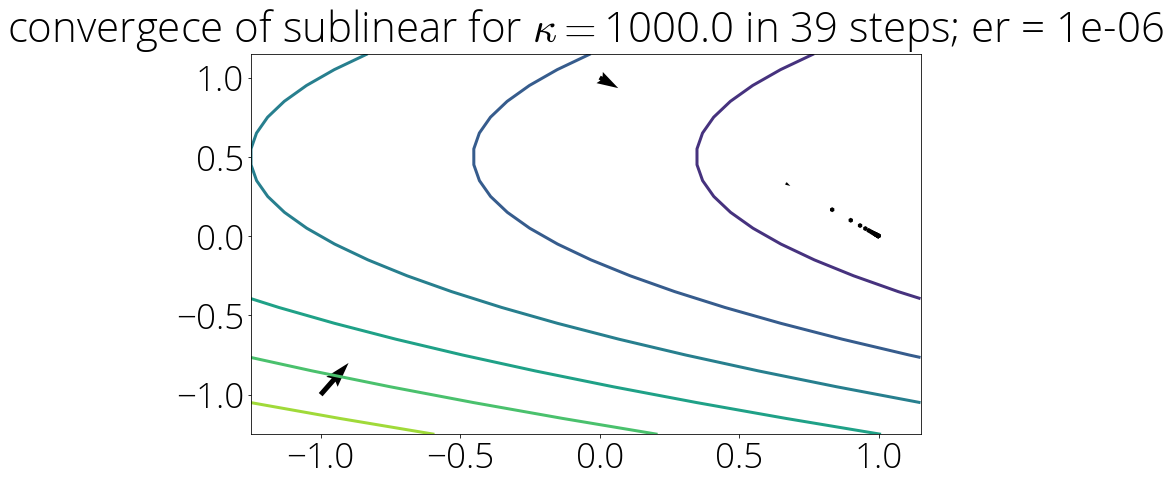

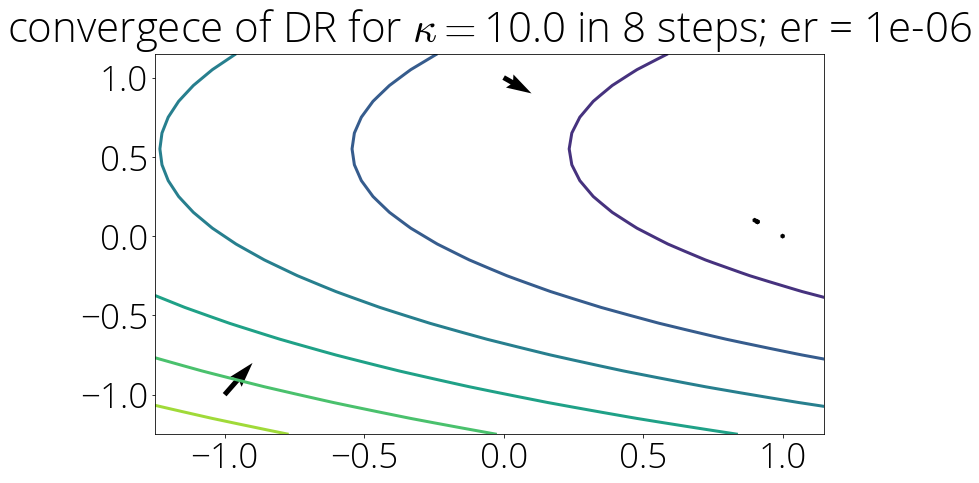

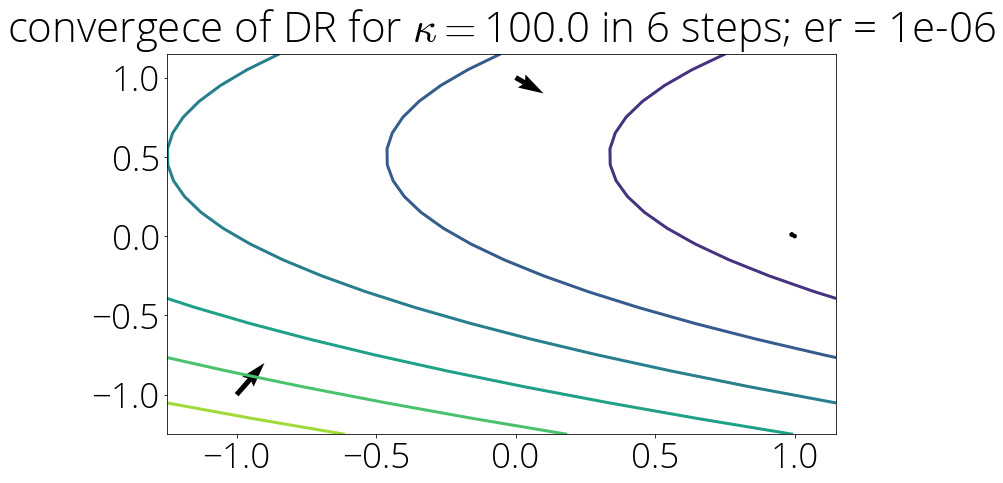

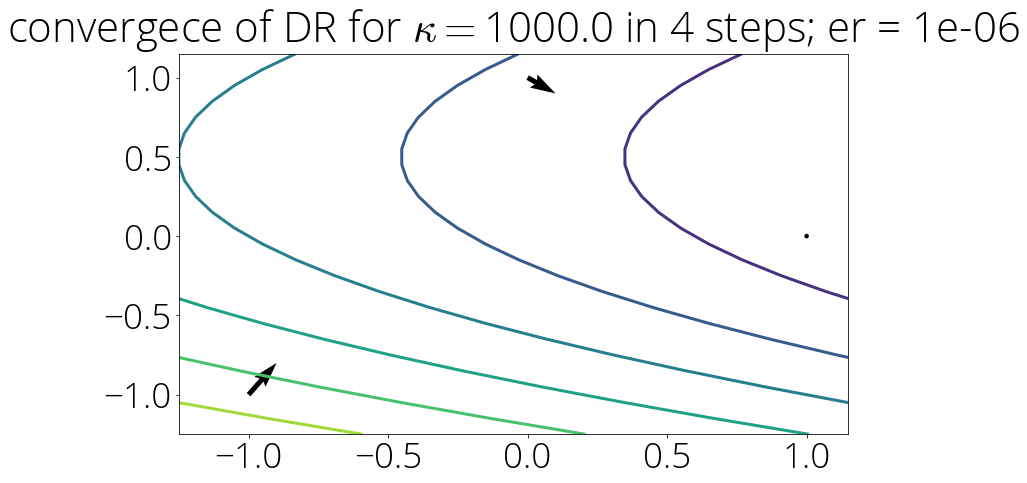

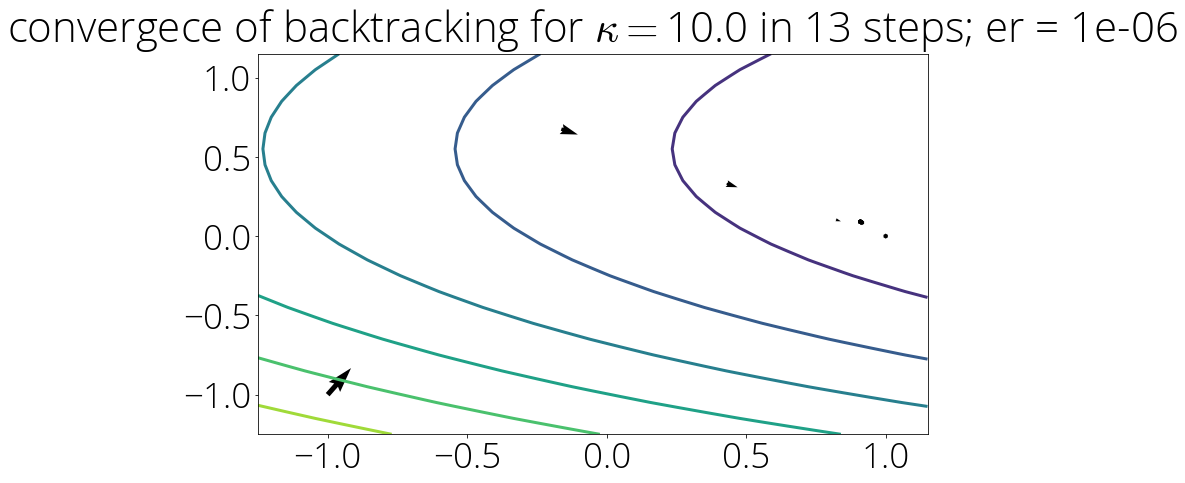

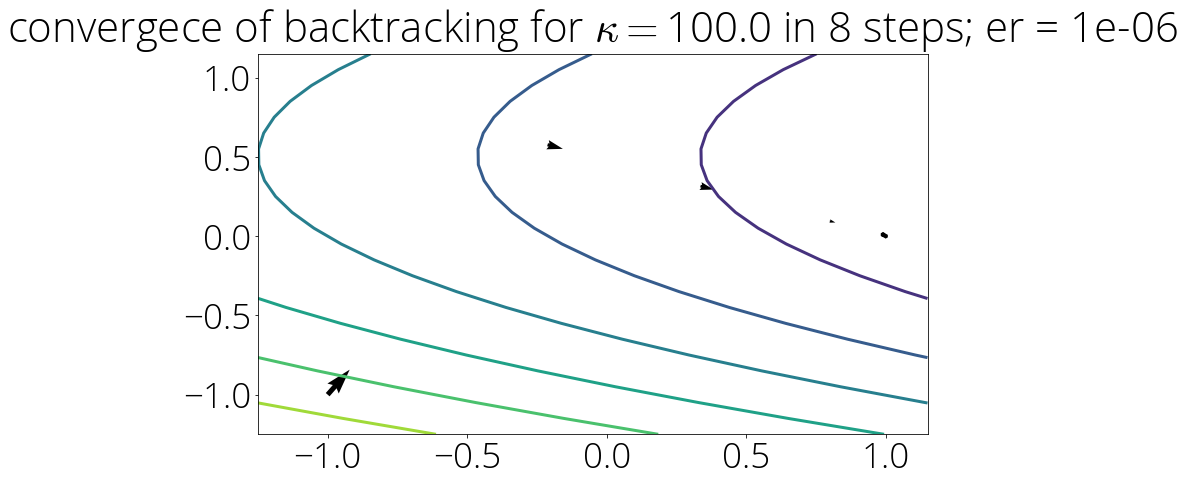

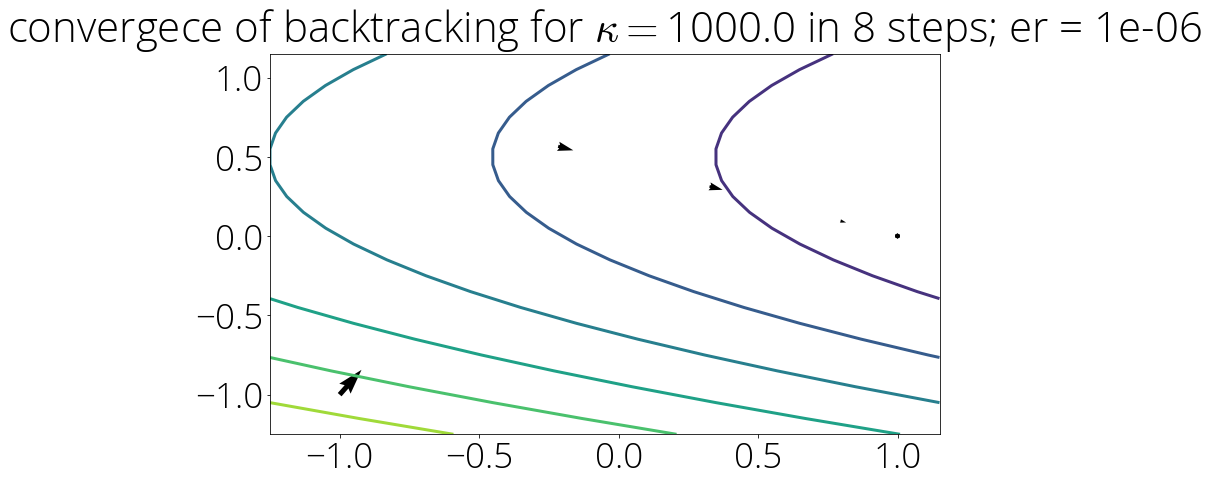

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copt as cp

# .. datasets and their loading functions ..
import copt.constraint
import copt.loss
class QuadraticForm:
    def __init__(self, A, b, alpha=0):
        self.b = b
        self.alpha = alpha
        self.A = A

    def __call__(self, x):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss

    def f_grad(self, x, return_gradient=True):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss, grad
    @property
    def lipschitz(self):
        return np.linalg.eig(self.A)[0].max()

colors = ['red', 'green', 'blue'] #'orange']

def plot_contours(f_grad, H, b, delta = 1e-1):
  x = np.arange(-1.25, 1.25, delta)
  y = np.arange(-1.25, 1.25, delta)
  X, Y = np.meshgrid(x, y)
  Z = np.empty_like(X)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Z[i, j] = f_grad((X[i, j], Y[i, j]), H, b)[0]
  
  fig, ax = plt.subplots(1, 1, figsize=(12, 7))
  tt = np.floor(np.linspace(0, np.sqrt(np.max(Z - np.min(Z))), 10) ** 2)
  cs = ax.contour(X, Y, Z - np.min(Z), linewidths=3)
  return ax
cns = []
iters = []
def f_grad(x, H, b):
  x = np.asarray(x)
  grad = 2 * H.dot(x) - b
  loss = x.dot(H).dot(x) - x.dot(b) 
  return loss, grad

class QuadraticForm:
    def __init__(self, A, b, alpha=0):
        self.b = b
        self.alpha = alpha
        self.A = A

    def __call__(self, x):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss

    def f_grad(self, x, return_gradient=True):
        x = np.asarray(x)
        grad = 2 * self.A.dot(x) - self.b
        loss = x.dot(self.A).dot(x) - x.dot(self.b) 
        return loss, grad
    @property
    def lipschitz(self):
        return np.abs(np.linalg.eig(self.A)[0]).max()
        
plt.figure(figsize = (12, 7))
j = 0
n = 2
b = np.array([1, 1])
for method in ['sublinear', 'DR', 'backtracking']:
  for k in [10, 100, 1000]:
    H = np.diag(np.random.choice(range(1, k-1), n))
    H[0,0]=1
    H[n-1,n-1]=k
    H = H/H.sum()

    cns.append(k)
    l1_ball = copt.constraint.L1Ball(1)
    f = QuadraticForm(H, b)
    x0 = np.array([-1, -1])
    
    error_rate = 1e-6
    #method = 'sublinear'
    #for step, label, marker in variants_fw:
    cb = Trace(f)
    if method == 'DR':
      sol = cp.minimize_frank_wolfe(
          f.f_grad, x0, l1_ball.lmo, callback=cb, step=method,tol = error_rate, lipschitz=f.lipschitz, max_iter = 30000
      )
    else:
      sol = cp.minimize_frank_wolfe(
          f.f_grad, x0, l1_ball.lmo, callback=cb, step=method,tol = error_rate, max_iter = 30000
      )
    ax = plot_contours(f_grad, H, b)
    cb.trace_x = np.array(cb.trace_x).T
    print(cb.trace_x.shape)
    ax.set_title(f'convergece of {method} for $\kappa=${np.linalg.cond(H)} in {cb._counter} steps; er = {error_rate}')
    ax.quiver(cb.trace_x[0,:-1], cb.trace_x[1,:-1], cb.trace_x[0,1:]-cb.trace_x[0,:-1], cb.trace_x[1,1:]-cb.trace_x[1,:-1], scale_units='xy', angles='xy', scale=10, color='k')
    #ax.scatter([x[0] for x in cb.trace_x], [x[1] for x in cb.trace_x], color=colors[0])

    #ax = plot_contours(f_grad)
    #ax.scatter([x[0] for x in cb.trace_x], [x[1] for x in cb.trace_x], color=colors[0])